## Список признаков

1. name - наименование модели автомобиля
2. year - год покупки авто
3. selling_price - цена продажи (значения целевой функции)
4. km_driven - пробег
5. fuel - тип топлива
6. seller_type - тип продавца
7. transmission - тип КПП
8. owner - число предыдущих владельцев авто
9. mileage - расход топлива (км/л)
10. engine - объем двигателя
11. max_power - мощность (л.с.)
12. torque - крутящий момент (Нм либо кгм @ обороты) 
13. seats - число мест

  

In [463]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import  LinearRegression, Lasso
from sklearn.svm import SVR

In [61]:
import warnings
warnings.filterwarnings("ignore")

In [410]:
df = pd.read_csv("Car details v3.csv")

In [3]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


Пропуски данных присутствуют в 5 признаках (4 - связаны с двигателем, последний - число мест)
## Предобработка
1. Пересчитаем крутящий момент всех автомобилей в Н * м, перейдя к единой системе счисления
2. Возьмем среднее значение диапозона частоты вращения двигателя при максимальном крутящем моменте
3. Используем one hot encoding для типа топлива, КПП
4. Разделим имя модели автомобиля на три части - марка, модель и описание конфигурации конкретного автомобиля. Так как в большинстве случаев описание конфигурации несет ту же информацию, что и остальные признаки (объем двигателя, тип топлива и т.д.), мы можем отбросить вторую часть названия, за счет чего сможем сильно уменьшить число признаков, получаемых в результате one hot encoding без значительного уменьшения получаемой в результате информации. В свою очередь марка автомобиля избыточна, так как различные модели различных марок в большинстве случаев имеют разные названия. 
 

In [411]:
def pattern_check(column, bad_symbols):
    df[f'{column}_patterns'] = df[column]

    for symbol in bad_symbols:
        df[f'{column}_patterns'] = df[f'{column}_patterns'].str.replace((symbol), '')

    df[f'{column}_patterns'] = df[f'{column}_patterns'].str.lower()
    print(df[f'{column}_patterns'].unique())
    # df = df.drop([f'{column}_patterns'], axis=1)

In [412]:
pattern_check('torque', ['\d+', ',', '.'])

['nm@ rpm' 'nm@ -rpm' '@ (kgm@ rpm)' ' kgm at -rpm' nan 'kgm@ rpm'
 'nm@ ~rpm' ' nm at  rpm' '@ -rpm' 'nm' 'nm at  rpm' ' kgm at  rpm'
 '@ -(kgm@ rpm)' ' nm at -rpm' ' nm at   rpm ' ' kgm at - rpm'
 ' nm at - rpm' 'nm at - rpm' 'nm(kgm)@ rpm' ' nm at  rpm ' 'nm@ -'
 'nm@ +/-rpm' '@ +/-(nm@ rpm)' '@ -' '()@ ' ' nm / rpm' 'nm@ ' ' / '
 ' nm at rpm' '  nm at   rpm ']


Как видим, во всех возможных значениях torque_patterns первое число - крутящий момент (кгм или Нм), второе (его может не быть) - нижняя граница частоты работы двигателя при данном крутящем моменте и третье (так же может не быть) - верхняя граница частоты 


In [413]:
df['torque_dimension'] = np.where(df['torque_patterns'].str.find('kgm') == -1, 1, 0) # кгм - 1, Нм - 0
df = df.drop([f'torque_patterns'], axis=1)

In [414]:
KGM2NM = 9.80665
df['torque'] = df['torque'].str.replace((','), '')
torquedf = df['torque'].str.extractall(r'(\d+[.]?\d+)').astype('float')

In [415]:
torquedf[0][:,]

      match
0     0         190.0
      1        2000.0
1     0         250.0
      1        1500.0
      2        2500.0
                ...  
8126  1        1800.0
      2        3000.0
8127  0         140.0
      1        1800.0
      2        3000.0
Name: 0, Length: 18482, dtype: float64

Заполним все пропуски медианой, более устойчивой к выбросам, чем среднее, и рассчитаем приблизительную частоту работы двигателя при максимальном крутящем моменте

In [416]:
df['torque'] = torquedf[0][:, 0]
df['freq_bot'] = torquedf[0][:, 1]
df['freq_high'] = torquedf[0][:, 2]

df['freq_high'] = df['freq_high'].fillna(df['freq_bot'])
df['freq'] = (df['freq_bot'] + df['freq_high']) / 2
freq_median = df['freq'].median()
df['freq'] = df['freq'].fillna(freq_median)

df['torque'] = np.where(df['torque_dimension'] == 0, df['torque'] * KGM2NM, df['torque'])
torque_median = df['torque'].median()
df['torque'] = df['torque'].fillna(torque_median)

df = df.drop(['freq_high', 'freq_bot', 'torque_dimension'], axis=1)

In [417]:
df['seats'] = df['seats'].fillna(5).astype('int')

In [418]:
df['engine'] = df['engine'].str.extract(r'(\d+)')
engine_median = df['engine'].median()
df['engine'] = df['engine'].fillna(engine_median).astype('int')

df['max_power'] = df['max_power'].str.extract(r'(\d+[.]?\d+)')
max_power_median = df['max_power'].median()
df['max_power'] = df['max_power'].fillna(max_power_median).astype('float')

In [419]:
df['mileage'] = df['mileage'].str.extract(r'(\d+[.]?\d+)')
mileage_median = df['mileage'].median()
df['mileage'] = df['mileage'].fillna(mileage_median).astype('float')

Разделим имя на оговоренные выше части и используем OHE.

In [420]:
name = df.pop('name')
name = [i[1] for i in name.str.split(' ', 2).values]
# df['name'] = pd.Series(name)
df = pd.get_dummies(df)
df['transmission'] = np.where(df['transmission_Manual'] == 1, 1, 0)
df = df.drop(['transmission_Manual', 'transmission_Automatic'], axis=1)

In [421]:
df.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,freq,fuel_CNG,...,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,transmission
0,2014,450000,145500,23.40,1248,74.00,190.000000,5,2000.0,0,...,0,0,1,0,1,0,0,0,0,1
1,2014,370000,120000,21.14,1498,103.52,250.000000,5,2000.0,0,...,0,0,1,0,0,0,1,0,0,1
2,2006,158000,140000,17.70,1497,78.00,124.544455,5,2700.0,0,...,1,0,1,0,0,0,0,0,1,1
3,2010,225000,127000,23.00,1396,90.00,219.668960,5,2250.0,0,...,0,0,1,0,1,0,0,0,0,1
4,2007,130000,120000,16.10,1298,88.20,112.776475,5,4500.0,0,...,1,0,1,0,1,0,0,0,0,1


In [422]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          8128 non-null   int64  
 1   selling_price                 8128 non-null   int64  
 2   km_driven                     8128 non-null   int64  
 3   mileage                       8128 non-null   float64
 4   engine                        8128 non-null   int64  
 5   max_power                     8128 non-null   float64
 6   torque                        8128 non-null   float64
 7   seats                         8128 non-null   int64  
 8   freq                          8128 non-null   float64
 9   fuel_CNG                      8128 non-null   uint8  
 10  fuel_Diesel                   8128 non-null   uint8  
 11  fuel_LPG                      8128 non-null   uint8  
 12  fuel_Petrol                   8128 non-null   uint8  
 13  sel

Теперь все данные без пропусков и имеют используемый тип

In [423]:
df.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,freq,fuel_CNG,...,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,transmission
count,8128.000000,8.128000e+03,8.128000e+03,8128.000000,8128.00000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,...,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000
mean,2013.804011,6.382718e+05,6.981951e+04,19.415554,1452.89813,91.325514,183.733838,5.405389,2871.032044,0.007013,...,0.446727,0.138533,0.832431,0.029035,0.650714,0.021407,0.258981,0.000615,0.068282,0.870817
std,4.044249,8.062534e+05,5.655055e+04,3.981922,498.19672,35.290213,293.286697,0.948874,979.177987,0.083453,...,0.497185,0.345480,0.373506,0.167916,0.476774,0.144747,0.438102,0.024796,0.252246,0.335423
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.00000,32.800000,47.071920,2.000000,1269.350000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,2.549990e+05,3.500000e+04,16.800000,1197.00000,69.000000,112.582356,5.000000,2000.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.00000,82.000000,170.000000,5.000000,2400.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2017.000000,6.750000e+05,9.800000e+04,22.277500,1582.00000,101.250000,205.000000,5.000000,4000.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.00000,400.000000,24516.625000,14.000000,21800.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

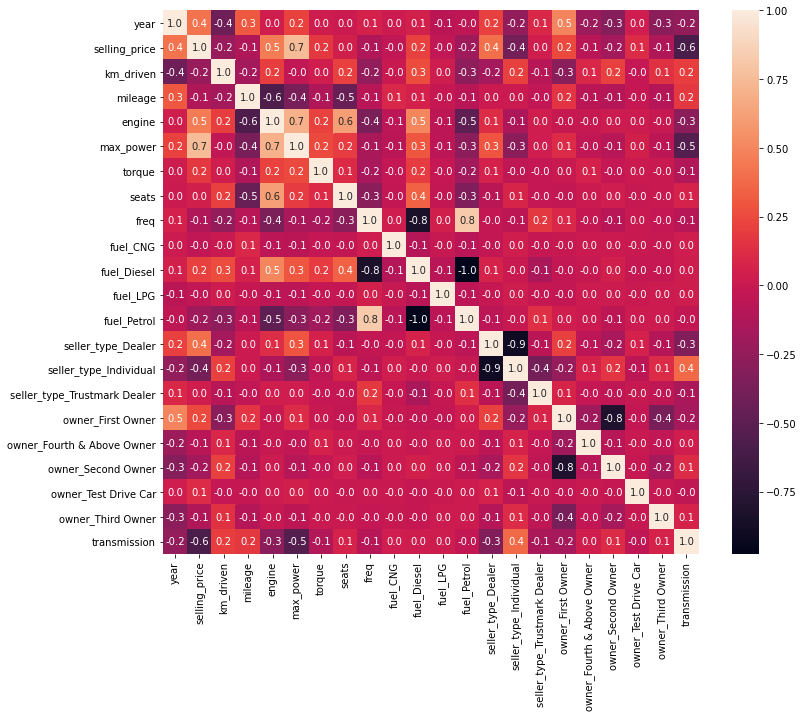

In [424]:
f,ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt= '.1f',ax=ax)

На рисунке выше видно, что больше всего коррелируют с ценой такие параметры как (по убыванию): максимальная мощность, тип КПП, объем двигателя, год продажи и тот факт, что продавцом был дилер. Рассмотрим зависимость некоторых признаков подробнее.

<AxesSubplot:xlabel='max_power', ylabel='selling_price'>

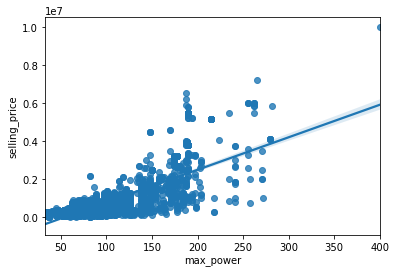

In [425]:
sns.regplot(x="max_power", y="selling_price", data=df)

<AxesSubplot:xlabel='engine', ylabel='selling_price'>

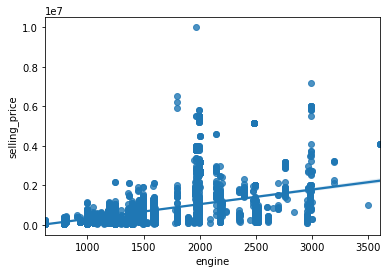

In [426]:
sns.regplot(x="engine", y="selling_price", data=df)

In [428]:
y = df.pop('selling_price')
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

## k ближайших соседей

Сперва масштабируем данные для корректной работы метода

In [445]:
knn_model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=1))
knn_model.fit(X_train, y_train)
knn_prediction = knn_model.predict(X_test)
knn_mae = mean_absolute_error(y_test, knn_prediction)
print(f"MAE = {knn_mae}")

MAE = 89306.05596555966


Text(0, 0.5, '$\\overarc{y}$')

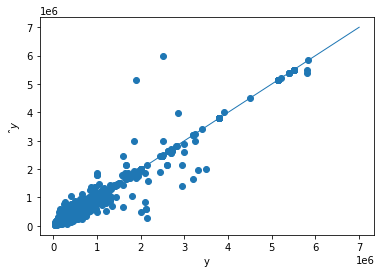

In [447]:
plt.scatter(y_test, knn_model.predict(X_test))
plt.plot([y_test.min(), 7e6], [y_test.min(), 7e6], lw=1)
plt.xlabel('y')
plt.ylabel('$\overarc{y}$')

## Линейная регрессия

In [431]:
lin_model = make_pipeline(StandardScaler(), LinearRegression())
lin_model.fit(X_train, y_train)
lin_prediction = lin_model.predict(X_test)
lin_mae = mean_absolute_error(y_test, lin_prediction)
print(f"MAE = {lin_mae}")

MAE = 269134.2868061209


Text(0, 0.5, '$\\overarc{y}$')

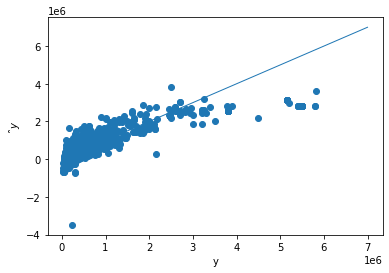

In [448]:
plt.scatter(y_test, lin_model.predict(X_test))
plt.plot([y_test.min(), 7e6], [y_test.min(), 7e6], lw=1)
plt.xlabel('y')
plt.ylabel('$\overarc{y}$')

Коэффициенты регрессии

In [433]:
pd.DataFrame(lin_model[1].coef_, index=df.columns, columns=['coef']).sort_values(by=['coef'], ascending= False)

,coef
max_power,472496.405012
year,150087.169907
fuel_Petrol,62982.458341
owner_Test Drive Car,55670.153768
seller_type_Dealer,49971.498511
mileage,48329.510017
engine,45656.796273
fuel_LPG,23731.674068
fuel_CNG,9879.005620
owner_First Owner,9008.410125


In [464]:
lasso_model = make_pipeline(StandardScaler(), Lasso())
lasso_model.fit(X_train, y_train)
lasso_prediction = lasso_model.predict(X_test)
lasso_mae = mean_absolute_error(y_test, lasso_prediction)
print(f"MAE = {lasso_mae}")

MAE = 269133.22017562645


In [465]:
pd.DataFrame(lasso_model[1].coef_, index=df.columns, columns=['coef']).sort_values(by=['coef'], ascending= False)

,coef
max_power,472496.604522
year,150086.249210
seller_type_Dealer,84328.737362
owner_Test Drive Car,56127.940890
mileage,48325.385394
engine,45648.392380
owner_First Owner,16881.604493
fuel_LPG,15143.247292
owner_Fourth & Above Owner,7251.211362
seller_type_Individual,2186.444856


Text(0, 0.5, '$\\overarc{y}$')

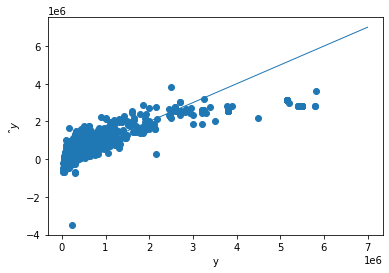

In [466]:
plt.scatter(y_test, lasso_model.predict(X_test))
plt.plot([y_test.min(), 7e6], [y_test.min(), 7e6], lw=1)
plt.xlabel('y')
plt.ylabel('$\overarc{y}$')

## Метод опорных векторов

In [458]:
svr_model = make_pipeline(StandardScaler(), SVR(C=1e6))
svr_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=1000000.0))])

In [459]:
svr_prediction = svr_model.predict(X_test)
svr_mae = mean_absolute_error(y_test, svr_prediction)
print(f"MAE = {svr_mae}")

MAE = 103578.05319239054


Text(0, 0.5, '$\\overarc{y}$')

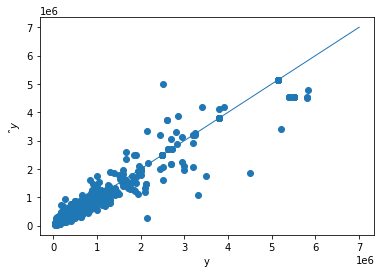

In [461]:
plt.scatter(y_test, svr_model.predict(X_test))
plt.plot([y_test.min(), 7e6], [y_test.min(), 7e6], lw=1)
plt.xlabel('y')
plt.ylabel('$\overarc{y}$')